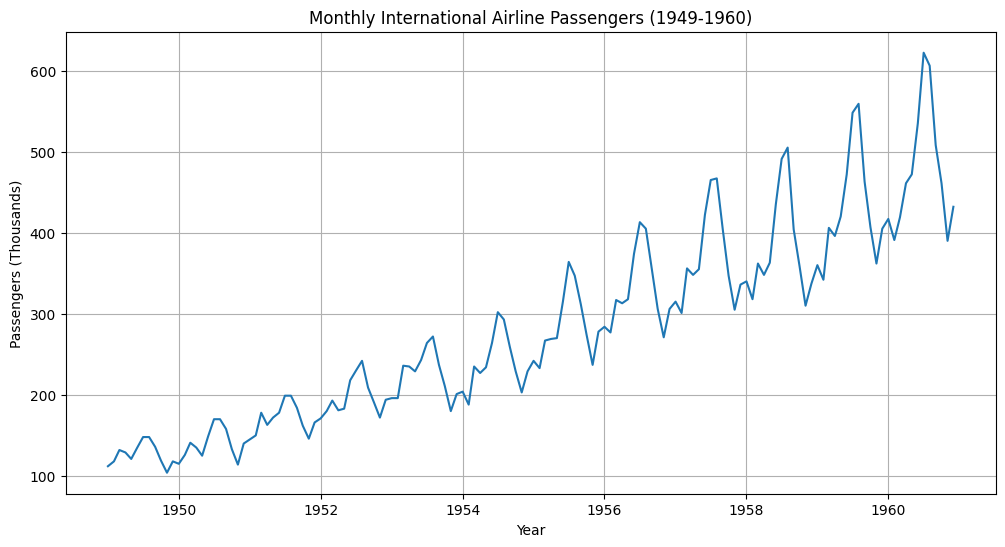

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
data.columns = ['Passengers']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data')
plt.title('Monthly International Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Passengers (Thousands)')
plt.grid()
plt.show()

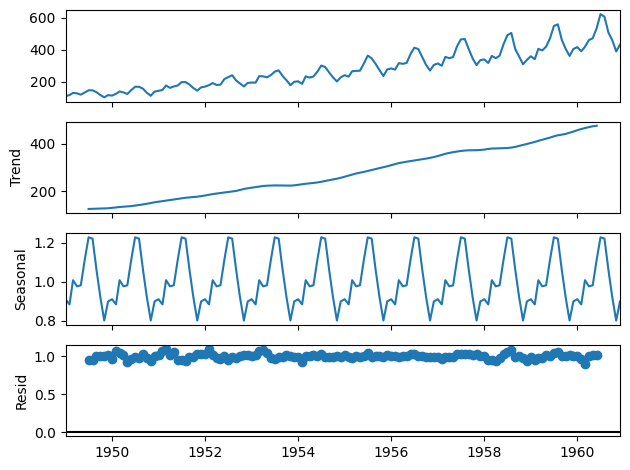

In [8]:
# Decompose into trend, seasonality, and residuals
decomposition = seasonal_decompose(data, model='multiplicative')
decomposition.plot()
plt.show()

In [9]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

adf_test(data['Passengers'])

ADF Statistic: 0.8153688792060497
p-value: 0.991880243437641
Critical Values: {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}


Conclusion: High p-value (0.991 > 0.05) → Non-stationary.

In [10]:
train = data.iloc[:-12]
test = data.iloc[-12:]

In [29]:
# Forecasting methods
# Simple methods
naive_forecast = test.shift(1) # Naive forecast
avg_forecast = train['Passengers'].mean() # Average forecast
ma_forecast = train['Passengers'].rolling(window=12).mean().iloc[-1] # Moving average forecast

In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train['Passengers']).fit()
ses_forecast = ses_model.forecast(12)

C:\Users\Sajid\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Holt's Linear Trend Model
holt_model = ExponentialSmoothing(train['Passengers'], trend='add').fit()
holt_forecast = holt_model.forecast(len(test))

C:\Users\Sajid\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Holt-Winters method
hw_model = ExponentialSmoothing(
    train['Passengers'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()
hw_forecast = hw_model.forecast(12)

C:\Users\Sajid\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA model
# Note: The order (p,d,q) should be determined based on ACF and PACe plots or using auto_arima
arima_model = ARIMA(train, order=(5,1,0)).fit()
arima_forecast = arima_model.forecast(len(test))

# Alternative ARIMA model with different parameters
arima_model_alt = ARIMA(train, order=(2,1,2)).fit()
arima_forecast_alt = arima_model_alt.forecast(len(test))

# SARIMA model

sarima_model = ARIMA(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
sarima_forecast = sarima_model.forecast(len(test))

C:\Users\Sajid\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sajid\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sajid\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sajid\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sajid\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473:

In [16]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
# StatsForecast AutoARIMA
forecaster = StatsForecastAutoARIMA(sp=12, seasonal=False)  # sp=12 for monthly data
forecaster.fit(train)
auto_forecast = forecaster.predict(fh=np.arange(1, 13))

In [17]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
# Prepare data for LSTM

# Scale data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Passengers']])

# Prepare sequences (window=12)
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return torch.FloatTensor(X), torch.FloatTensor(y)

X, y = create_sequences(scaled_train, window=12)

# Define LSTM model
class LSTMForecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

model = LSTMForecaster()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train
for epoch in range(20):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Predict (similar to your original code)
test_seq = torch.FloatTensor(scaled_train[-12:].reshape(1, 12, 1))
preds = []
for _ in range(len(test)):
    with torch.no_grad():
        pred = model(test_seq)
    preds.append(pred.item())
    test_seq = torch.cat((test_seq[:, 1:, :], pred.reshape(1, 1, 1)), dim=1)

lstm_forecast = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

C:\Users\Sajid\AppData\Local\Temp\ipykernel_177776\3530950169.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.FloatTensor(X), torch.FloatTensor(y)


In [18]:
from sklearn.linear_model import LinearRegression

# Linear Regression as a simple forecasting method
X = np.arange(len(train)).reshape(-1, 1)
y = train.values
model = LinearRegression().fit(X, y)
X_test = np.arange(len(train), len(train)+len(test)).reshape(-1, 1)
linear_forecast = model.predict(X_test)

# Exponential Regression
log_y = np.log(y)
exp_model = LinearRegression().fit(X, log_y)
exp_forecast = np.exp(exp_model.predict(X_test))

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_forecast(forecast, actual):
    
    # Convert to numpy arrays
    forecast_arr = np.array(forecast).flatten()
    actual_arr = np.array(actual).flatten()
    
    # Align lengths
    min_len = min(len(actual_arr), len(forecast_arr))
    if min_len == 0:
        return np.nan, np.nan, np.nan
    
    forecast_arr = forecast_arr[:min_len]
    actual_arr = actual_arr[:min_len]
    
    # Remove NaNs
    mask = ~np.isnan(forecast_arr)
    forecast_arr = forecast_arr[mask]
    actual_arr = actual_arr[mask]
    
    if len(forecast_arr) == 0:
        return np.nan, np.nan, np.nan
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actual_arr, forecast_arr))
    mae = mean_absolute_error(actual_arr, forecast_arr)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.nanmean(np.abs((actual_arr - forecast_arr) / actual_arr)) * 100
    
    return rmse, mae, mape

# Evaluation code
results = {
    name: evaluate_forecast(forecast, test['Passengers'])
    for name, forecast in models.items()
}

results_df = pd.DataFrame(
    [(model, *metrics) for model, metrics in results.items()],
    columns=['Model', 'RMSE', 'MAE', 'MAPE']
).sort_values('RMSE')

print(results_df)

                Model        RMSE         MAE       MAPE
3        Holt-Winters   16.979896   13.380419   2.802816
8              SARIMA   21.194953   16.323102   3.679522
7           ARIMA_alt   55.222839   41.834798   8.220491
0               Naive   55.396915   48.272727  10.053668
11       Linear Trend   78.822731   58.657860  11.385005
12  Exponential Trend   79.366727   69.715954  15.212932
9          Auto-ARIMA   85.957084   63.012338  12.065408
6               ARIMA   86.810130   67.389003  13.407129
1          Moving Avg   88.473160   63.888889  12.055751
4                Holt   93.533840   67.200221  12.587427
2                 SES  103.124454   76.142579  14.279017
10               LSTM  138.278925  115.685259  22.536001
5             Average  226.265671  213.674242  43.621522


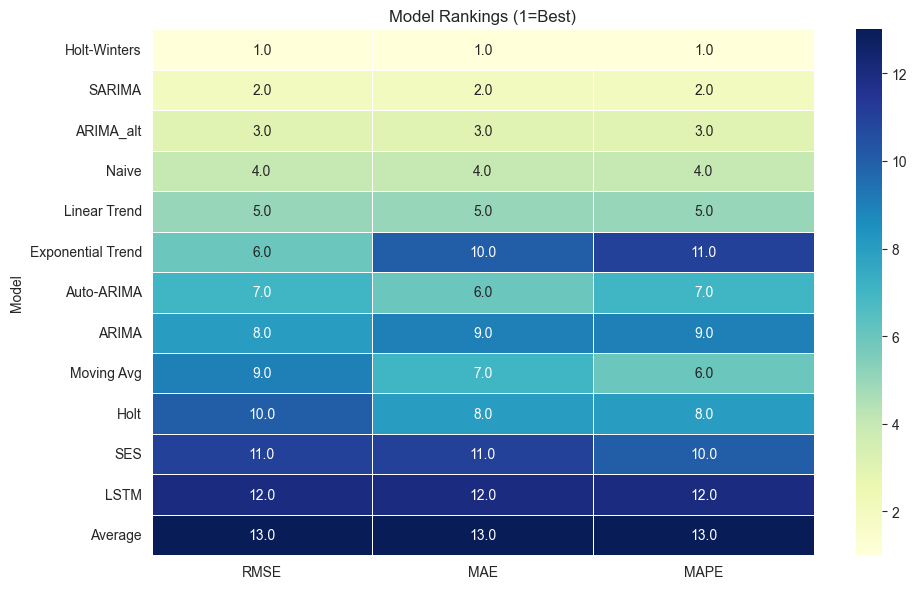

In [63]:
import seaborn as sns
# Create ranking for each metric
rank_df = results_df.copy()
for col in ['RMSE', 'MAE', 'MAPE']:
    rank_df[col] = rank_df[col].rank(ascending=True)

plt.figure(figsize=(10, 6))
# Sort the DataFrame by RMSE before plotting
sorted_rank_df = rank_df.sort_values('RMSE').set_index('Model')[['RMSE', 'MAE', 'MAPE']]
sns.heatmap(sorted_rank_df, 
            annot=True, cmap="YlGnBu", fmt=".1f",
            linewidths=.5)
plt.title("Model Rankings (1=Best)")
plt.tight_layout()
plt.show()

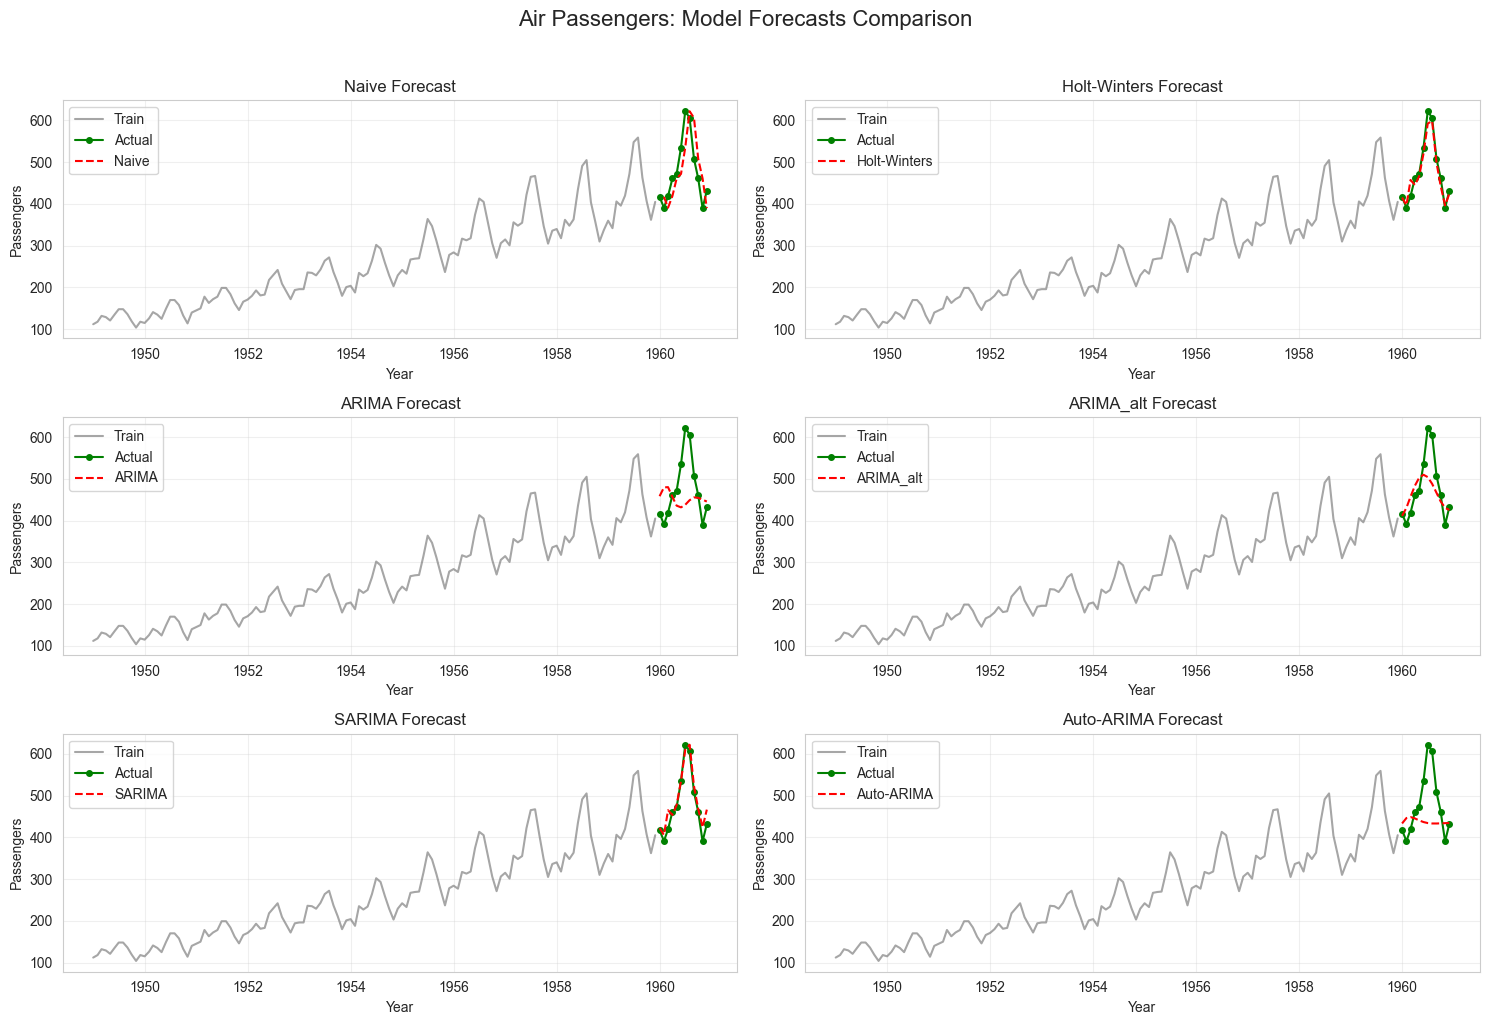

In [56]:

# Plotting the forecasts of selected models for comparison
# Selected models for comparison
selected_models = {
    'Naive': naive_forecast['Passengers'],
    'Holt-Winters': hw_forecast,
    'ARIMA': arima_forecast,
    'ARIMA_alt': arima_forecast_alt,
    'SARIMA': sarima_forecast,
    'Auto-ARIMA': auto_forecast
}

# Create 3x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Air Passengers: Model Forecasts Comparison', fontsize=16, y=1.02)

# Plot each model in its own subplot
for ax, (model_name, forecast) in zip(axes.flatten(), selected_models.items()):
    # Plot train, test, and forecast
    ax.plot(train.index, train['Passengers'], label='Train', color='gray', alpha=0.7)
    ax.plot(test.index, test['Passengers'], label='Actual', color='green', marker='o', markersize=4)
    ax.plot(test.index, forecast, label=model_name, color='red', linestyle='--')
    
    # Customize subplot
    ax.set_title(f'{model_name} Forecast', fontsize=12)
    ax.set_xlabel('Year')
    ax.set_ylabel('Passengers')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

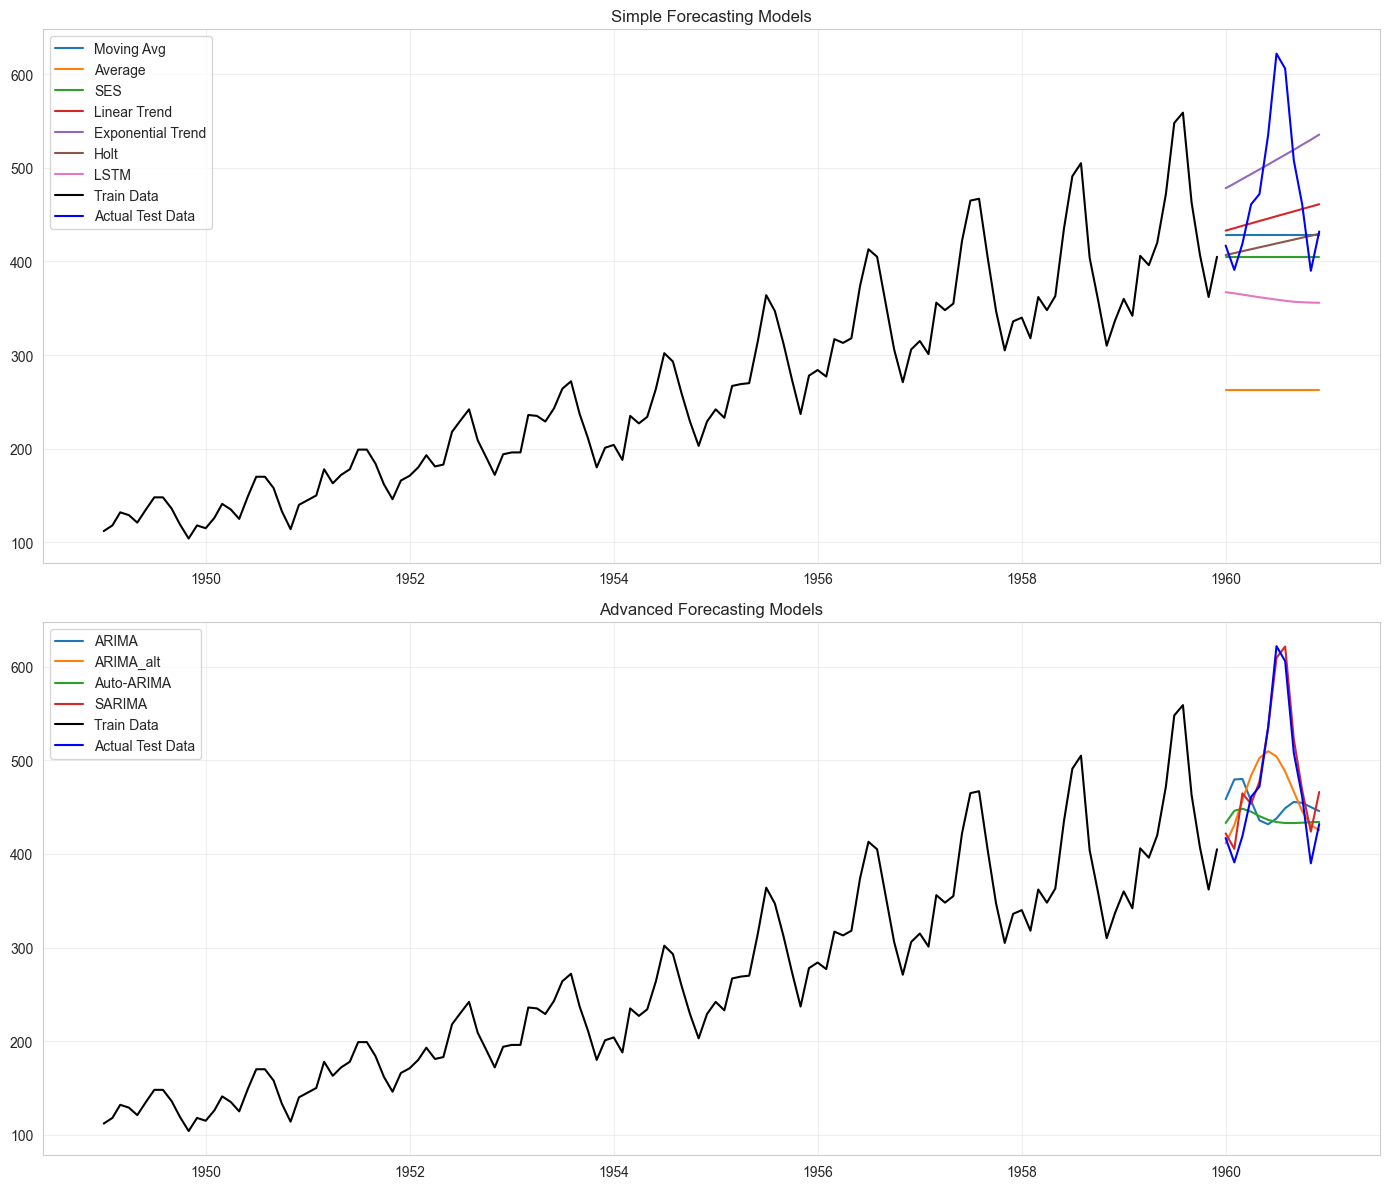

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Under Performed models
simple_models = ['Moving Avg', 'Average', 'SES', 'Linear Trend', 'Exponential Trend', 'Holt', 'LSTM'] 
for name in simple_models:
    ax1.plot(test.index, models[name], label=name)
ax1.set_title('Under Performed Forecasting Models', fontsize=12)

# Arima models
advanced_models = ['ARIMA', 'ARIMA_alt', 'Auto-ARIMA', 'SARIMA']  
for name in advanced_models:
    ax2.plot(test.index, models[name], label=name)
ax2.set_title('Arima Forecasting Models', fontsize=12)

# Shared elements
for ax in [ax1, ax2]:
    ax.plot(train.index, train['Passengers'], color='black', label='Train Data')
    ax.plot(test.index, test['Passengers'], color='blue', label='Actual Test Data')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()